In [57]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count
from finite_tight_binding import TightBindingHamiltonian
import scipy.constants as spc

In [58]:
class EffectiveMass(TightBindingHamiltonian):
    def __init__(self, N, sparseSetting = False):
        super().__init__(N)
        self.sparse_setting = True
        
        # sparse parameter
        self.sigma = 0.55 # start values of eigenvalues
        self.eigenRange = 10 # amount of computed eigenvalues (initially 10)
        self.cbm = {}
        self.vbm = {}
        self.cbmValue = [0,np.inf]
        self.vbmValue = [0, -np.inf]
        self.Nk = 40
        self.a = 5.431e-10

        
    def make_mp_grid(self,Nk):
        """Return an (Nk3, 3) array of fractional k-vectors (0 … 1) in the 1st BZ."""
        shifts = np.linspace(0, 1, Nk, endpoint=False) + 0.5/Nk   
        klist  = np.array(list(product(shifts, repeat=2)))        

        return klist                                             
    # helper method 
    def frac_shift(self, k_frac, delta):
        return (k_frac + delta) #% 1.0
    def _sparse_eval(self, k, sigma, m):
        """Return eigenvalue array (sorted) for a given σ and range m."""
        ev, _ = self.create_tight_binding_sparse(k, self.N,
                                                 sigma=sigma,
                                                 eigRange=m)
        return np.asarray(ev)
    
    #--------------------------Sparse calculations-----------------------------
    def analyzeEnergyRange(self, k, energies=None, effectiveMassCalc=False,
                           max_iter=25, grow=5, σ_step=0.2):

        if energies is None:
            energies = self._sparse_eval(k, self.sigma, self.eigenRange)

        for _ in range(max_iter):

            has_pos = np.any(energies > 0)
            has_neg = np.any(energies < 0)
            if has_pos and has_neg:
                # collect extrema
                min_pos_idx = np.argmin(energies[energies > 0])
                max_neg_idx = np.argmax(energies[energies < 0])

                min_positive = energies[energies > 0][min_pos_idx]
                max_negative = energies[energies < 0][max_neg_idx]

                # bookeeping
                if not effectiveMassCalc:
                    self.cbm[tuple(k)] = [min_positive, self.sigma, self.eigenRange]
                    if min_positive < self.cbmValue[1]:
                        self.cbmValue = [k, min_positive]

                    self.vbm[tuple(k)] = [max_negative, self.sigma, self.eigenRange]
                    if max_negative > self.vbmValue[1]:        # less negative is “larger”
                        self.vbmValue = [k, max_negative]

                # --------- prepare next k‑point search ----------------------
                self.sigma = 0.5 * (min_positive + max_negative)
                self.eigenRange = 5                           # reset to a lean window

                # fast exit for EM‑tensor path
                if effectiveMassCalc:
                    return min_positive

                return                                          # ← success
            band_min, band_max = energies.min(), energies.max()

            if not has_pos:              # whole window ≤ 0  →  move σ ↑
                self.sigma += max(σ_step, 0.5*abs(band_min))   # adaptive drift
            elif not has_neg:            # whole window ≥ 0  →  move σ ↓
                self.sigma -= max(σ_step, 0.5*abs(band_max))

            # widen the window a little every time we fail
            self.eigenRange += grow

            energies = self._sparse_eval(k, self.sigma, self.eigenRange)

        # ---------- could not bracket zero within max_iter -------------------
        print(f"[warn] unable to bracket E=0 at k={k} after {max_iter} trials")
        if effectiveMassCalc:
            return None          # caller must handle this case
        
    
    def eval_k_sparse(self, k_frac):
        eigenvalues, H = self.create_tight_binding_sparse(np.array([0,0]), sigma=self.sigma, eigRange= self.eigenRange)
        self.analyzeEnergyRange(k_frac, eigenvalues)
    
    def determineInitialSparseSettings(self):
        k = np.array([0,0])
        eigenvalues, H = self.create_tight_binding_sparse(np.array([0,0]), sigma=self.sigma, eigRange= self.eigenRange)
        self.analyzeEnergyRange(k, eigenvalues)
    
    def scan_full_BZ(self, Nk=30, store_all=True, n_jobs=None, a=5.431e-10, res_factor=4):
        self.Nk = Nk
        klist = self.make_mp_grid(Nk)
        #print(klist)
        for k in klist:
            self.eval_k_sparse(k)
    
    def calculateEffectiveMass(self, startk = np.array([0,0]), resolution=4):
        

        def E(k_frac):
            evs = self.analyzeEnergyRange(k_frac,effectiveMassCalc=True)
            #print(evs, k_frac)
            return evs

        delta_frac = 1.0 / (self.Nk * resolution)
        dk = (2 * np.pi / self.a) * delta_frac

        k0 = np.asarray(startk, float)
        #print(f"this the min {E(k0)}")
        ei = np.eye(2)
        H = np.zeros((2,2))
        for i in range(2):
            # second derivative along axis i
            kp = self.frac_shift(k0,  +delta_frac * ei[i])
            km = self.frac_shift(k0,  -delta_frac * ei[i])
            H[i,i] = (E(kp) + E(km) - 2*E(k0)) / dk**2

            # mixed derivatives
            for j in range(i+1, 2):
                kpp = self.frac_shift(k0, +delta_frac*ei[i] + delta_frac*ei[j])
                kmm = self.frac_shift(k0, -delta_frac*ei[i] - delta_frac*ei[j])
                kpm = self.frac_shift(k0, +delta_frac*ei[i] - delta_frac*ei[j])
                kmp = self.frac_shift(k0, -delta_frac*ei[i] + delta_frac*ei[j])
                H[i,j] = H[j,i] = (E(kpp)+E(kmm)-E(kpm)-E(kmp)) / (4*dk**2)

        H_J = H * spc.e
        mstar_SI = spc.hbar**2 * np.linalg.inv(H_J)
        mstar_me = mstar_SI / spc.m_e

        return mstar_me

        

        

In [59]:
effectiveMass = EffectiveMass(1)
m = effectiveMass.calculateEffectiveMass(resolution = 400)
print(m)

[[ 2.09577327e-01 -1.10161089e-09]
 [-1.10161089e-09  2.09577320e-01]]


In [60]:
effectiveMassData = [None] * 30

for i in range(1, 31):
    effectiveMass = EffectiveMass(i)
    m = effectiveMass.calculateEffectiveMass(resolution = 40)
    prin_m, prin_axes = np.linalg.eigh(m)
    #print(m)
    effectiveMassData[i - 1] = prin_m


[array([0.20957774, 0.20957774]), array([0.20098063, 0.20098063]), array([0.20270666, 0.20270666]), array([0.20342719, 0.20342719]), array([0.20170639, 0.20170639]), array([0.20196169, 0.20196169]), array([0.20209994, 0.20209994]), array([0.20152324, 0.20152324]), array([0.20165511, 0.20165511]), array([0.20139715, 0.20139715]), array([0.20143361, 0.20143361]), array([0.20150809, 0.20150809]), array([0.20133875, 0.20133875]), array([0.201384, 0.201384]), array([0.20142318, 0.20142318]), array([0.20131276, 0.20131277]), array([0.20135173, 0.20135173]), array([0.20128531, 0.20128532]), array([0.20129898, 0.20129899]), array([0.20132785, 0.20132786]), array([0.20127106, 0.20127107]), array([0.20129005, 0.20129005]), array([0.20130856, 0.20130856]), array([0.20126434, 0.20126435]), array([0.20128291, 0.20128292]), array([0.20129225, 0.20129225]), array([0.20126097, 0.20126098]), array([0.2012763 , 0.20127632]), array([0.20124859, 0.20124862]), array([0.20125886, 0.20125887])]


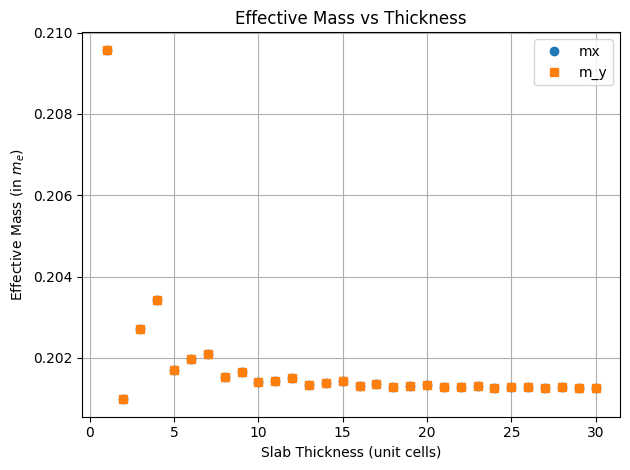

In [64]:
import numpy as np
import matplotlib.pyplot as plt
print(effectiveMassData)
mxx = np.array([val[0] for val in effectiveMassData])
myy = np.array([val[-1] for val in effectiveMassData])
thickness = np.array([i for i in range (1,31)])

plt.figure()
plt.plot(thickness, mxx, 'o', label='mx')
plt.plot(thickness, myy, 's', label='m_y')
plt.xlabel('Slab Thickness (unit cells)')
plt.ylabel('Effective Mass (in $m_e$)')
plt.title('Effective Mass vs Thickness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
